In [1]:
# --- edit these three paths ---
# H5_FILE     = "./data/sevir_lr/data/vil/2019/SEVIR_VIL_STORMEVENTS_2019_0101_0630.h5"
H5_FILE     = "./data/sevir_lr/data/vil/2017/SEVIR_VIL_STORMEVENTS_2017_0101_0630.h5"
CKPT_PATH   = "./checkpoints/latest.pt"
TASK_CONFIG = "./configs/super_resolution_config.yaml"  # for noise (dps.measurements)

EVENT_IDX   = 0   # which event in this file
IN_LEN      = 6
OUT_LEN     = 6
EM_STEPS    = 200  # sampling steps (like original); you can lower to ~200 if slow

DEVICE = "cuda"  # or "cpu"


In [2]:
import os, h5py, yaml, math, numpy as np
from types import SimpleNamespace

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# repo-local imports (same as original)
from utils_forlookback_sevir_vil import DriftModel
from interpolant_new import Interpolant
from dps.measurements import get_noise
from tqdm import tqdm


In [3]:
def load_one_event_vil(h5_path, event_idx, in_len=6, out_len=6):
    """
    Returns:
      z0 (1, in_len, 1, H, W) in model scale ((x - 0.5) * 10)
      z1 (1, out_len, 1, H, W) in model scale ((x - 0.5) * 10)
    Assumes raw values in [0,1]. If your file stores different ranges,
    normalize to [0,1] before the scaling below.
    """
    with h5py.File(h5_path, "r") as f:
        # typical dataset key is 'vil' in SEVIR-LR VIL files
        ds = f["vil"] if "vil" in f.keys() else list(f.values())[0]
        arr = ds[...]  # numpy

    # Robust-ish handling of layout
    # Common shapes: (N_events, H, W, T) or (H, W, T)
    if arr.ndim == 4:
        # assume (N, H, W, T)
        x = arr[event_idx]  # (H, W, T)
    elif arr.ndim == 3:
        # assume (H, W, T)
        x = arr
    else:
        raise ValueError(f"Unexpected array shape: {arr.shape}")

    H, W, T = x.shape
    assert (in_len + out_len) <= T, "Not enough frames in this event/file"

    # take first (in_len + out_len) frames
    x = x[:, :, : (in_len + out_len)]  # (H, W, in_len+out_len)

    # ensure float32 in [0,1]; if not, normalize here
    x = x.astype(np.float32)
    if x.max() > 1.0 or x.min() < 0.0:
        # min-max normalize per-event as a fallback; adjust if needed
        xmin, xmax = x.min(), x.max()
        x = (x - xmin) / max(1e-6, (xmax - xmin))

    # split & scale exactly like original Trainer.prepare_batch_sevir
    xlo = x[:, :, :in_len]      # (H, W, in_len)
    xhi = x[:, :, in_len:]      # (H, W, out_len)

    # to torch (1, T, 1, H, W)
    xlo = torch.from_numpy(xlo).permute(2, 0, 1).unsqueeze(0).unsqueeze(2)  # (1,T,1,H,W)
    xhi = torch.from_numpy(xhi).permute(2, 0, 1).unsqueeze(0).unsqueeze(2)  # (1,T,1,H,W)

    # model scale: (x - 0.5) * 10
    z0 = (xlo - 0.5) * 10
    z1 = (xhi - 0.5) * 10
    return z0, z1

z0, z1 = load_one_event_vil(H5_FILE, EVENT_IDX, IN_LEN, OUT_LEN)
z0 = z0.to(DEVICE)
z1 = z1.to(DEVICE)
H, W = z0.shape[-2], z0.shape[-1]
print("z0:", tuple(z0.shape), "z1:", tuple(z1.shape))


z0: (1, 6, 1, 128, 128) z1: (1, 6, 1, 128, 128)


In [4]:
# minimal config carrying only what's needed
c = SimpleNamespace(
    dataset='sevir', device=DEVICE,
    sigma_coef=1.0, beta_fn='t^2',
    t_min_sampling=0.0, t_max_sampling=0.999,
    EM_sample_steps=EM_STEPS,
    # UNet/arch (must match training)
    num_classes=1,
    C=1, H=H, W=W,
    unet_use_classes=False,
    unet_channels=128,
    unet_dim_mults=(1, 2, 2, 2),
    unet_resnet_block_groups=8,
    unet_learned_sinusoidal_dim=32,
    unet_attn_dim_head=64,
    unet_attn_heads=4,
    unet_learned_sinusoidal_cond=True,
    unet_random_fourier_features=False,
)

I = Interpolant(c)
model = DriftModel(c).to(DEVICE)
state = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(state['model_state_dict'])
model.eval()


NOT USING CLASSES IN UNET
Num params in main arch for drift is 30,020,113


DriftModel(
  (_arch): Unet(
    (init_conv): Conv2d(7, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (time_mlp): Sequential(
      (0): RandomOrLearnedSinusoidalPosEmb()
      (1): Linear(in_features=33, out_features=512, bias=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=512, out_features=512, bias=True)
    )
    (downs): ModuleList(
      (0): ModuleList(
        (0-1): 2 x ResnetBlock(
          (mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=512, out_features=256, bias=True)
          )
          (block1): Block(
            (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
            (act): SiLU()
          )
          (block2): Block(
            (proj): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm): GroupNorm(8, 128, eps=1e-05, affine=True)
            (act): SiLU()
          )
 

In [5]:
# Load noise from YAML (same as original)
with open(TASK_CONFIG) as f:
    task_config = yaml.load(f, Loader=yaml.FullLoader)
measure_config = task_config['measurement']
noiser = get_noise(**measure_config['noise'])

# replace your mask/operator cell with this
ratio = 0.1
mask = (torch.rand(1, 1, 1, H, W, device=DEVICE) < ratio).float()  # broadcastable

def operator(x):
    # x can be (B, 1, H, W), (B, T, 1, H, W), or (B, 1, 1, H, W)
    return x * mask  # broadcasting does the right thing


In [6]:
@torch.no_grad()
def em_unguided(base, cond, steps, sigma_fn, drift_fn):
    """
    base: (B,1,H,W)   most recent frame
    cond: (B,IN_LEN,1,H,W)  conditioning window used by the drift
    """
    B = base.shape[0]
    xt = base.clone()

    ts = torch.linspace(I.config.t_min_sampling, I.config.t_max_sampling, steps, device=xt.device)
    dt = ts[1] - ts[0]
    for t in ts:
        tvec = t.repeat(B)
        bF   = drift_fn(xt, tvec, cond)                      # (B,1,H,W)
        g    = sigma_fn(tvec).view(B,1,1,1)
        mu   = xt + bF * dt
        xt   = mu + g * torch.randn_like(mu) * dt.sqrt()
    return xt


def taylor_est2rd_x1(xt, t, bF, cond, drift_fn):
    """
    The analytical second-order estimator used by the original code
    (MC_times == 1 path). t is (B,).
    """
    # noise term: 2/3 - sqrt(t) + (1/3)(sqrt(t))^3
    t_s   = torch.sqrt(t).view(-1,1,1,1)         # (B,1,1,1)
    eps_c = (2.0/3.0 - t_s + (1.0/3.0)*(t_s**3))
    hat   = xt + bF * (1 - t.view(-1,1,1,1)) + torch.randn_like(xt) * eps_c

    t1    = torch.ones_like(t)
    bF2   = drift_fn(hat, t1, cond)              # drift at t=1 for hat_x1
    hat   = xt + (bF + bF2) / 2 * (1 - t.view(-1,1,1,1)) + torch.randn_like(xt) * eps_c
    return hat.requires_grad_(True)


def grad_and_value(x_prev, x0_hat, measurement):
    """
    measurement: (B,1,1,H,W)   observed (masked+noised) GT for this step in model scale
    x0_hat: (B,1,H,W)          estimate of x1 used to compute guidance gradient
    """
    # measurement is already noised operator(z1); in original they compute
    # (measurement - noiser(operator(x0_hat))). Here we apply the same structure:
    diff = (measurement - noiser(operator(x0_hat.unsqueeze(1)))).requires_grad_(True)  # (B,1,1,H,W)
    norm = torch.linalg.norm(diff)  # scalar
    grad = torch.autograd.grad(outputs=norm, inputs=x_prev, allow_unused=True)[0]
    return grad, norm


def em_guided(base, cond, steps, sigma_fn, drift_fn, measurement, guidance_scale=0.1):
    """
    base: (B,1,H,W)
    cond: (B,IN_LEN,1,H,W)
    measurement: (B,1,1,H,W) for the current step (operator+noise on GT), in model scale
    """
    B = base.shape[0]
    xt = base.clone().requires_grad_(True)

    ts = torch.linspace(I.config.t_min_sampling, I.config.t_max_sampling, steps, device=xt.device)
    dt = ts[1] - ts[0]

    for t in ts:
        tvec = t.repeat(B)
        bF   = drift_fn(xt, tvec, cond).requires_grad_(True)
        g    = sigma_fn(tvec)                      # (B,)

        # 2nd-order estimate of x1
        hat_x1    = taylor_est2rd_x1(xt, tvec, bF, cond, drift_fn)
        norm_grad, _ = grad_and_value(xt, hat_x1, measurement)

        mu = xt + bF * dt
        g4 = g.view(B,1,1,1)
        if norm_grad is None:
            norm_grad = 0
        xt = mu + g4 * torch.randn_like(mu) * dt.sqrt() - guidance_scale * norm_grad

    return xt


In [7]:
def drift_fn(xt, tvec, cond_time):
    # cond_time: (B, IN_LEN, 1, H, W) -> (B, IN_LEN, H, W)
    cond4 = cond_time.squeeze(2) if cond_time.dim() == 5 else cond_time
    return model(xt, tvec, None, cond=cond4)

def sigma_fn(tvec):
    return I.sigma(tvec)


In [8]:
@torch.no_grad()
def rollout_unguided(z0_time, steps):
    """
    z0_time: (B, IN_LEN, 1, H, W)
    returns (B, steps, 1, H, W)
    """
    B = z0_time.shape[0]
    cond = z0_time.clone()
    outs = []
    for s in tqdm(range(steps)):
        base = cond[:, -1]              # (B,1,H,W)
        x1   = em_unguided(base, cond, EM_STEPS, sigma_fn, drift_fn)
        outs.append(x1.unsqueeze(1))
        cond = torch.cat([cond[:, 1:], x1.unsqueeze(1)], dim=1)
    return torch.cat(outs, dim=1)


def rollout_guided(z0_time, steps, measurements, guidance_scale=0.1):
    """
    z0_time: (B, IN_LEN, 1, H, W)
    measurements: (B, steps, 1, H, W) in model scale; each step's masked+noised GT
    """
    B = z0_time.shape[0]
    cond = z0_time.clone()
    outs = []
    for s in tqdm(range(steps)):
        base = cond[:, -1]                  # (B,1,H,W)
        meas = measurements[:, s]           # (B,1,H,W) -> need (B,1,1,H,W) for our function
        x1   = em_guided(base, cond, EM_STEPS, sigma_fn, drift_fn,
                         measurement=meas.unsqueeze(1), guidance_scale=guidance_scale)
        outs.append(x1.unsqueeze(1))
        cond = torch.cat([cond[:, 1:], x1.unsqueeze(1)], dim=1)
    return torch.cat(outs, dim=1)


In [9]:
with torch.no_grad():
    y = noiser(operator(z1))  # (B, OUT_LEN, 1, H, W)

In [10]:
pred_u = rollout_unguided(z0, OUT_LEN)             # (1, OUT_LEN, 1, H, W)
pred_g = rollout_guided(z0, OUT_LEN, y, 0.1)       # (1, OUT_LEN, 1, H, W)


100%|██████████| 6/6 [02:42<00:00, 27.14s/it]


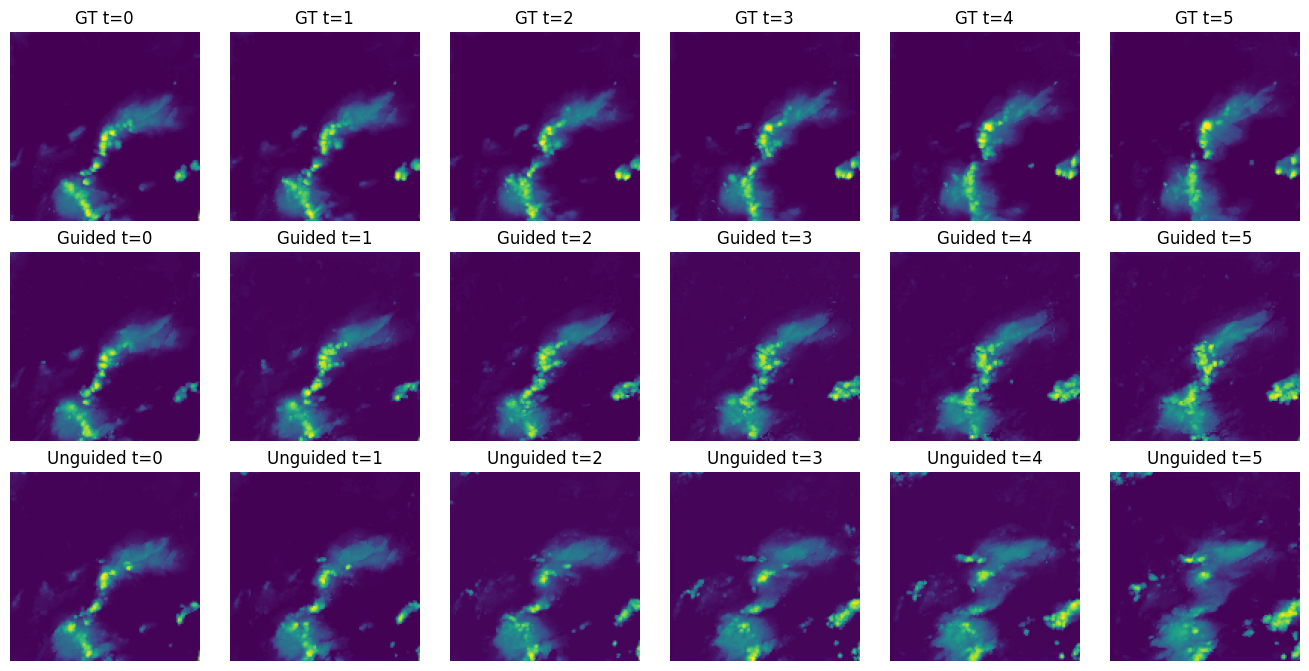

In [11]:
# convert back to display scale [0,1] like original visualization did: (x/10 + 0.5)
gt  = (z1[0,:,0].detach().cpu().numpy() / 10.0 + 0.5)
pg  = (pred_g[0,:,0].detach().cpu().numpy() / 10.0 + 0.5)
pu  = (pred_u[0,:,0].detach().cpu().numpy() / 10.0 + 0.5)

T = OUT_LEN
fig, axs = plt.subplots(3, T, figsize=(2.2*T, 6.6), constrained_layout=True)

for t in range(T):
    axs[0, t].imshow(gt[t], origin="upper"); axs[0, t].set_title(f"GT t={t}");  axs[0, t].axis("off")
    axs[1, t].imshow(pg[t], origin="upper"); axs[1, t].set_title(f"Guided t={t}"); axs[1, t].axis("off")
    axs[2, t].imshow(pu[t], origin="upper"); axs[2, t].set_title(f"Unguided t={t}"); axs[2, t].axis("off")

plt.show()


In [21]:
z0.min()

tensor(-5., device='cuda:0')